In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Suicide_Detection_clean.csv", header=None)


df = df[[2, 3]]
df[3] = (df[3] == "suicide").astype(int)
df[2] = df[2].astype(str)
df = df.rename({3: "target", 2: "text"}, axis=1)
df = df[:][1:]
df

<ipython-input-2-e2d8adc6f334>:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Suicide_Detection_clean.csv", header=None)


,text,target
0,text,0
1,ex wife threatening suiciderecently i left my ...,1
2,am i weird i dont get affected by compliments ...,0
3,finally 2020 is almost over so i can never hea...,0
4,i need helpjust help im crying so hard,1
...,...,...
232070,if you dont like rock then your not going to g...,0
232071,you how you can tell i have so many friends an...,0
232072,pee probably tastes like salty tea can someone...,0
232073,the usual stuff you find hereim not posting th...,1


In [ ]:
# скачиваю локально библиотеку transformers для работы с готовыми моделями с hugging face
# можно добавить в отчет, что мы использовали эту библиотеку
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.0 MB/s eta 0:00:00


In [ ]:
import IPython
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
from transformers import pipeline

fill_mask_pipeline = pipeline('fill-mask', model='distilroberta-base')
fill_mask_pipeline("Hello I'm a <mask> model."), fill_mask_pipeline.model.lm_head

([{'score': 0.04673680663108826,
   'token': 265,
   'token_str': ' business',
   'sequence': "Hello I'm a business model."},
  {'score': 0.03846096992492676,
   'token': 18150,
   'token_str': ' freelance',
   'sequence': "Hello I'm a freelance model."},
  {'score': 0.03308930993080139,
   'token': 2734,
   'token_str': ' fashion',
   'sequence': "Hello I'm a fashion model."},
  {'score': 0.0301900003105402,
   'token': 774,
   'token_str': ' role',
   'sequence': "Hello I'm a role model."},
  {'score': 0.021117402240633965,
   'token': 24526,
   'token_str': ' Playboy',
   'sequence': "Hello I'm a Playboy model."}],
 RobertaLMHead(
   (dense): Linear(in_features=768, out_features=768, bias=True)
   (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
   (decoder): Linear(in_features=768, out_features=50265, bias=True)
 ))

In [ ]:
CLASS_NAMES = sorted(set(df.target))
CLASS_NAMES

[0, 1]

In [ ]:
# убираем голову берта и включаем cuda
fill_mask_pipeline.model.lm_head = nn.Identity()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
# класс эмбеддингов, метод индексации __getitem__ возвращает эмбеддинг текста

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

class EmbeddingsOfTextDataset(Dataset):
    def __init__(self, df, fill_mask_pipeline, class_names=CLASS_NAMES, device=device):
        self.df = df
        self.tokenizer = fill_mask_pipeline.tokenizer
        self.preprocessor_model = fill_mask_pipeline.model
        self.preprocessor_model.lm_head = nn.Identity()
        self.preprocessor_model = self.preprocessor_model.to(device)
        self.class_names = CLASS_NAMES
        super().__init__()
    
    # метод возвращает длину эмбеддинга
    def __len__(self):
        return len(self.data)
    
    # метод возвращает эмбеддинг текста с данным индексом в датасете
    def __getitem__(self, index):
        tweet_info = self.df.iloc[index]
        X = self.tokenizer(
            tweet_info['text'],
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )["input_ids"]

        X = X.to(device)
        with torch.no_grad():
          # берем сумму токенов берта
            X = self.preprocessor_model.forward(X)[-1][0].sum(axis=0)

      # подключение cpu для ускорения обучения модели
        t = X.to(torch.device("cpu"))
        del X
        return t, tweet_info["target"]

train_data, test_data = train_test_split(df)
train_dataset = EmbeddingsOfTextDataset(train_data, fill_mask_pipeline)
test_dataset = EmbeddingsOfTextDataset(test_data, fill_mask_pipeline)

In [ ]:
df.head()

,text,target
1,ex wife threatening suiciderecently i left my ...,1
2,am i weird i dont get affected by compliments ...,0
3,finally 2020 is almost over so i can never hea...,0
4,i need helpjust help im crying so hard,1
5,im so losthello my name is adam 16 and ive bee...,1


In [ ]:
# дисбаланса класса нет
df['target'].sum() / len(df['target'])

0.5

In [ ]:
# размерность эмбеддинга
len(test_dataset.__getitem__(1)[0])

768

In [ ]:
# преобразование датасетов из текстов в эмбеддинги
from tqdm.auto import tqdm
X_train, y_train = [], []
for X, Y in tqdm(train_dataset, total=len(train_data)):
    X_train.append(X)
    y_train.append(Y)


X_test, y_test = [], []
for X, Y in tqdm(test_dataset, total=len(test_data)):
    X_test.append(X)
    y_test.append(Y)

  0%|          | 0/174054 [00:00<?, ?it/s]

  0%|          | 0/58019 [00:00<?, ?it/s]

In [ ]:
# сохраняю датасеты в GoogleDrive

n = "suicide_texts"
folder = "/content/drive/MyDrive/"
with open(f"{folder}/train_X{n}.txt", "wb") as f:
    torch.save(X_train, f)

with open(f"{folder}/train_Y{n}.txt", "wb") as f:
    torch.save(y_train, f)


with open(f"{folder}/test_X{n}.txt", "wb") as f:
    torch.save(X_test, f)

with open(f"{folder}/test_Y{n}.txt", "wb") as f:
    torch.save(y_test, f)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif, SelectKBest
from sklearn.linear_model import LogisticRegression

In [ ]:
class DatasetFromFile:
    def __init__(self, x_filepath, y_filepath):
        self.x = torch.load(x_filepath)
        self.y = torch.load(y_filepath)
        
    def __getitem__(self, index):
        return self.x[index], torch.Tensor([self.y[index]]).float()
    
    def __len__(self):
        return len(self.x)

In [ ]:
# экспорт данных из GoogleDrive
m = "suicide_texts"
chosen_folder = "/content/drive/MyDrive/"
train_dataset_from_file = DatasetFromFile(f"{chosen_folder}/train_X{m}.txt", f"{chosen_folder}/train_Y{m}.txt")
test_dataset_from_file = DatasetFromFile(f"{chosen_folder}/test_X{m}.txt", f"{chosen_folder}/test_Y{m}.txt")

In [ ]:
train_X = np.stack(train_dataset_from_file.x, axis=0)
train_y = np.stack(train_dataset_from_file.y, axis=0)
test_X = np.stack(test_dataset_from_file.x, axis=0)
test_y = np.stack(test_dataset_from_file.y, axis=0)

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb

In [ ]:
# размер обучающего датасета 
train_X.shape

(174054, 768)

In [ ]:
# размер тестового датасета
test_X.shape

(58019, 768)

Далее представлено в основном две модели: градиентный бустинг LightGBM и логистическая регрессия. Для каждой модели пайплайн выглядит следующим образом: обучение модели, предсказание на тестовой выборке, вычисление метрик классификации и максимизация порога для таргета. 

LightGBM Boosting

In [ ]:
LGBM_clf = lgb.LGBMClassifier()

In [ ]:
LGBM_clf.fit(train_X, train_y)

LGBMClassifier()

In [ ]:
print('ROC AUC train: ', roc_auc_score(train_y, LGBM_clf.predict_proba(train_X)[:, 1]))
print('ROC AUC test: ', roc_auc_score(test_y, LGBM_clf.predict_proba(test_X)[:, 1]))

NameError: ignored

In [ ]:
print(classification_report(test_y, LGBM_clf.predict((test_X))))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92     28921
           1       0.93      0.92      0.92     29098

    accuracy                           0.92     58019
   macro avg       0.92      0.92      0.92     58019
weighted avg       0.92      0.92      0.92     58019



In [ ]:
y_pred_proba_lgb = LGBM_clf.predict_proba(train_X)[:, 1]

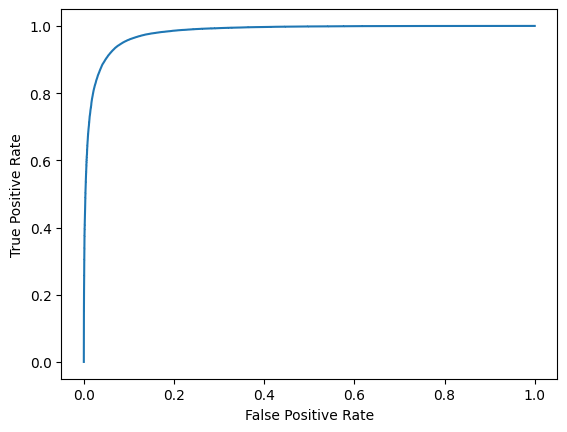

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(train_y, y_pred_proba_lgb, pos_label=LGBM_clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

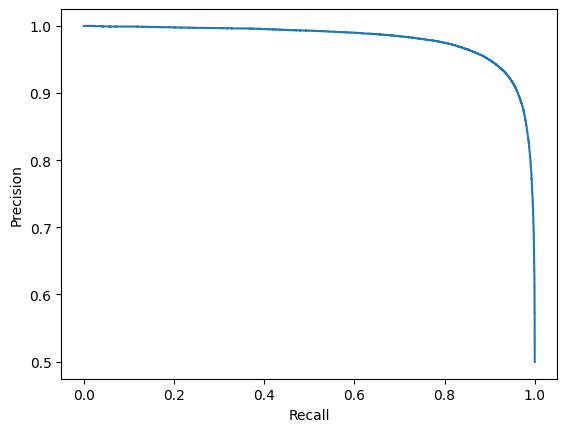

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(train_y, y_pred_proba_lgb, pos_label=LGBM_clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [ ]:
def best_threshold(y_true, y_pred_proba, metric = 'recall', min_accuracy = 0.65):
  
  
  #Функция выдает порог, максимизирующий фиксированную метрику классификации
  #y_true - реальные значения таргета
  #y_pred_proba - предсказанные вероятности
  #metric - метрика классификации: recall, precision, f1
  #min_accuracy - минимальная точность алгоритма

    max_metric_value = 0
    max_alpha = 0
    accuracy = 0
    enter_flg = False
    for alpha in np.linspace(0, 1.0, 1000):
        y_pred = (y_pred_proba >= alpha).astype(bool)
        if accuracy_score(y_true, y_pred) >= min_accuracy:
            enter_flg = True
            if metric == 'recall':
                if recall_score(y_true, y_pred) > max_metric_value:
                    max_alpha = alpha
                    max_metric_value = recall_score(y_true, y_pred)
                    accuracy = accuracy_score(y_true, y_pred)
            if metric == 'precision':
                if recall_score(y_true, y_pred) > max_metric_value:
                    max_alpha = alpha
                    max_metric_value = precision_score(y_true, y_pred)
                    accuracy = accuracy_score(y_true, y_pred)
            if metric == 'f1':
                if recall_score(y_true, y_pred) > max_metric_value:
                    max_alpha = alpha
                    max_metric_value = f1_score(y_true, y_pred)
                    accuracy = accuracy_score(y_true, y_pred)
                
    if enter_flg:
        return {'Threshold' : max_alpha, 'Metric': metric, metric: max_metric_value, 'Accuracy' : accuracy}
    else:
        return f'Не подходит условию Accuracy >= {min_accuracy}'

In [ ]:
best_threshold(train_y, y_pred_proba_lgb, metric = 'f1')

{'Threshold': 0.48148148148148145,
 'Metric': 'f1',
 'f1': 0.9321609918514983,
 'Accuracy': 0.932222183919933}

Logistic Regression

In [ ]:
clf_lr = LogisticRegression()

In [ ]:
clf_lr.fit(train_X, train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
print('ROC AUC train: ', roc_auc_score(train_y, clf_lr.predict_proba(train_X)[:, 1]))
print('ROC AUC test: ', roc_auc_score(test_y, clf_lr.predict_proba(test_X)[:, 1]))

ROC AUC train:  0.9714599283916265
ROC AUC test:  0.9714606839616557


In [ ]:
print(classification_report(test_y, clf_lr.predict((test_X))))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     28921
           1       0.94      0.89      0.92     29098

    accuracy                           0.92     58019
   macro avg       0.92      0.92      0.92     58019
weighted avg       0.92      0.92      0.92     58019



In [ ]:
y_pred_proba_lr = clf_lr.predict_proba(train_X)[:, 1]

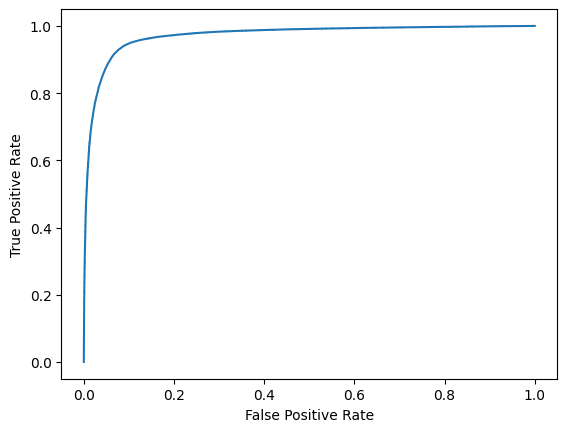

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(train_y, y_pred_proba_lr, pos_label=clf_lr.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

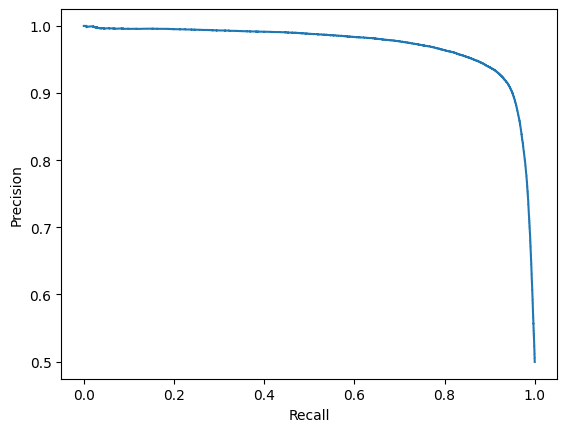

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(train_y, y_pred_proba_lr, pos_label=clf_lr.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [ ]:
best_threshold(train_y, y_pred_proba_lr, metric = 'f1')

{'Threshold': 0.38383838383838387,
 'Metric': 'f1',
 'f1': 0.9262707685957047,
 'Accuracy': 0.9261148838866099}

KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

knn_clf.fit(train_X, train_y)

KNeighborsClassifier()

In [ ]:
print(classification_report(test_y, knn_clf.predict((test_X))))

In [ ]:
print('ROC AUC train: ', roc_auc_score(train_y, knn_clf.predict_proba(train_X)[:, 1]))
print('ROC AUC test: ', roc_auc_score(test_y, knn_clf.predict_proba(test_X)[:, 1]))

In [ ]:
# сохранение моделей в формате pkl для дальнейшего использования в Rstudio

import pickle
pickle.dump(clf_lr, open('model.pkl', 'wb'))
pickle.dump(LGBM_clf, open('model_lgb.pkl', 'wb'))

In [ ]:
import pickle
clf_lr = pickle.load(open('model.pkl', 'rb'))
LGBM_clf = pickle.load(open('model_lgb.pkl', 'rb'))

In [ ]:
# примеры предсказаний на тестовой выборке
for i in range(10):
  print(test_data.iloc[i].text)
  print('Real: ', test_data.iloc[i].target == 1)
  print('Prediction: ', clf_lr.predict_proba(test_X)[:, 1][i] >= 0.393939393939394)
  print('Probability: ', clf_lr.predict_proba(test_X)[:, 1][i])
  print('~~~~~~~~')


i forced myself to keep going i cant do it anymoreposted on here about year ago nothings changed hope
Real:  True
Prediction:  False
Probability:  0.2562078081635901
~~~~~~~~
fuck youi want to die i fucking hate everyone and everything i want to break everything and cannot not fuck up i ruin everything i do and can never seem to do anything right i want to fucking break everyones back across my knee and burn them alive i cant do wellll enough in school for anyone to be truly happy i have insane anxiety on where i will go to college and how i will do in life i hate myself more than anyone else because of my inability to ever to anything right why the hell was i born i didnt want to be born i want to break everything and am often filled with rage because of how much of failure i am i fucking hate how my family never shuts the hell up and argues about everything and i mean everything i hate that i dont have many friends and im unsure you could even call them that my only true friend was m

In [ ]:
for i in range(10):
  print(test_data.iloc[i].text)
  print('Real: ', test_data.iloc[i].target == 1)
  print('Prediction: ', LGBM_clf.predict_proba(test_X)[:, 1][i] >= 0.481)
  print('Probability: ', LGBM_clf.predict_proba(test_X)[:, 1][i])
  print('~~~~~~~~')

im boycotting online classes i had to do online classes since the second semester of 8th grade in 2019 im not going to do anymore online classesid rather be unschooled than do online classesi dont give shit about coronafuck coronai need human interactionreopen my school ffs
Real:  False
Prediction:  False
Probability:  0.06820205360775199
~~~~~~~~
32 f with my ex 32 m decade later still ruining my lifei got drunk and let rip on all of the emotionally abusive bs pulledin few hours will either have blocked or ignored i do not even care which i just want people past and present to respect my choices and my body i may be in pit of anxiety and depression right now and wine support is needed i had his abortioni tried to say we needed to talk about it all but wasnt interested now his gf is accidentally pregnant ad sees it as project and wants clone of him m 32 things have come to head and i have messaged him all of this i doubt i willl get reply and i am on my own tl dr had exs abortion did n

In [ ]:
print(classification_report(test_y, LGBM_clf.predict_proba((test_X))[:, 1] >= 0.481))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     28921
           1       0.92      0.92      0.92     29098

    accuracy                           0.92     58019
   macro avg       0.92      0.92      0.92     58019
weighted avg       0.92      0.92      0.92     58019



In [ ]:
from sklearn.ensemble import StackingClassifier
estimators = [('logreg', clf_lr), ('lgb', LGBM_clf)]

clf = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression()
)

clf.fit(train_X, train_y).score(test_X, test_y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

0.9271962632930592